# LIDAR Sensor Outdoor Tests

## Objective

Determine Garmin's LIDAR Lite V4's capability in detecting and gauging distances of vehicles in genuine outdoor settings.

## Experiment Details

### Experiment Setup

1. **Stationary Test**: The sensor was initially mounted on a stationary bike alongside a busy road to gauge its proficiency in detecting passing vehicles.
2. **Dynamic Test**: Retaining the setup, the bike was ridden by a food delivery rider, collecting data from vehicles overtaking the cyclist. This step transitioned the evaluation from a controlled setting to a more dynamic environment, offering insights into real-world applicability.

### Data Extraction

- **Raspberry Pi**: As before, data from the sensor was published over to AWS IoT's message broker via MQTT. I then extracted the data in to text files. Each line of measurement contains the time, distance, and signal strength:

    ```text
    10:45:37 1623 4
    ```

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`outdoor_graphs.py`](../src/graphing/outdoor_graphs.py) provides utilities for data visualization.

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("../src")

from data import analysis, cleaner, loader, processing
from graphing import outdoor_graphs

### Data Preparation and Loading

I load the data collected from the stationary tests.

In [2]:
YUAN_CHING_RD_1 = pathlib.Path("../data/processed/lidar_outdoor_tests/yuan_ching_rd_1.txt")
YUAN_CHING_RD_2 = pathlib.Path("../data/processed/lidar_outdoor_tests/yuan_ching_rd_2.txt")
JURONG_WEST_RIDE = pathlib.Path("../data/processed/lidar_outdoor_tests/jurong_west_ride.txt")

## Stationary Test

In the first test, the sensor was mounted on a stationary bike along Yuan Ching Rd. which saw moderate traffic. I also mounted a Go Pro to capture a video of the vehicles that passed the bike. I cross referenced the data collected from the sensor and the Go Pro's video feed to determine the reliability of the sensor.

### Raw Data Analysis 1

- **Scatter Plot Observations**: At a glance, the sensor appears to reliably detect passing vehicles as seen from the clusters of dark points on the graph. However, it also appears to generate spurious data as seen from the individual points scattered throughout the graph, especially above 3.5m.
- **Data Cleaning Objective**: Therefore, a cleaning algorithm could be used to improve the reliability of the sensor by removing these spurious points while keeping the clusters.

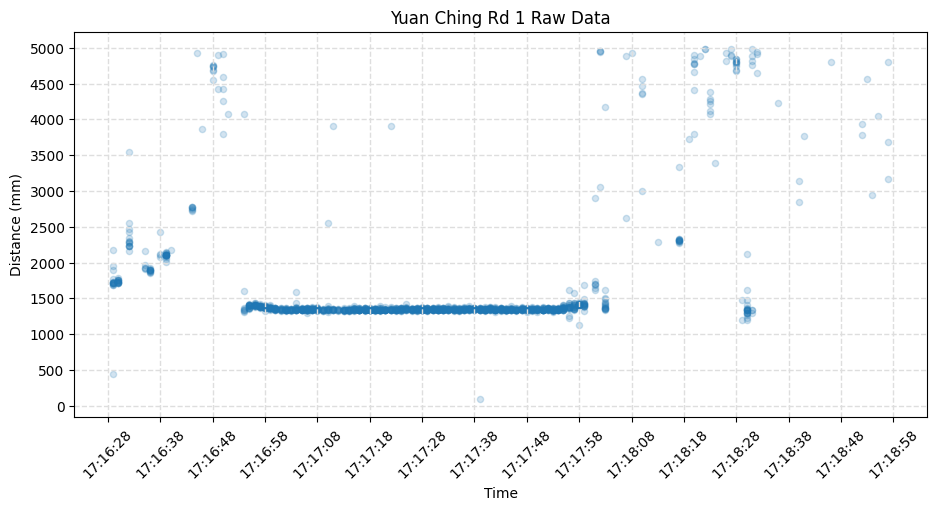

In [3]:
timings, distances, strengths = loader.filter_data_from_file(YUAN_CHING_RD_1, 5000)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 1 Raw Data", intervals=10, rotate_xticks=True)
plt.show()

### Data Cleaning Algorithm

- **Cluster Identification**: Using the same cleaning algorithm as for the TOF sensor, distances that weren't in proximity (within two points) of other distances were removed, ensuring a minimum cluster size of 2 points.
- **Graphical Representation**: After cleaning, the spurious points appear to be removed while keeping the clusters representing the vehicle passes.

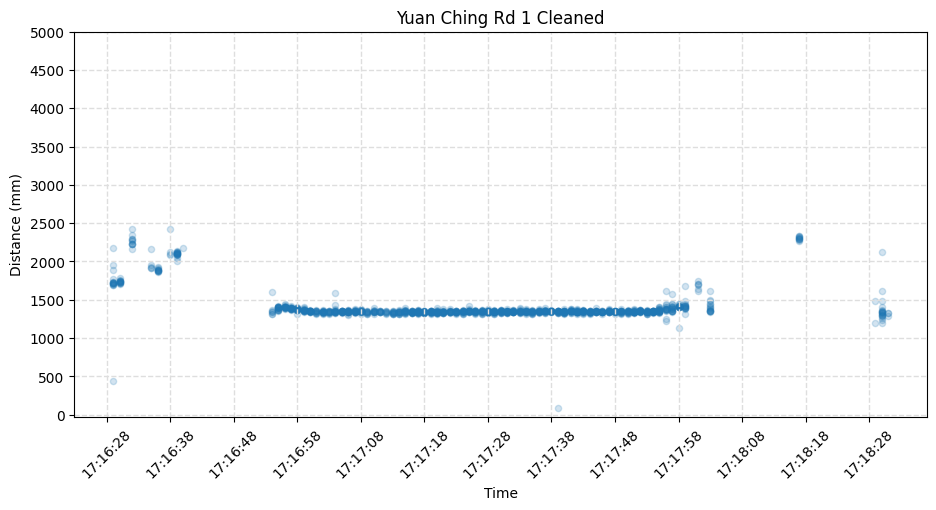

In [4]:
fig, axes = plt.subplots(figsize=(11, 5))
cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Yuan Ching Rd 1 Cleaned", intervals=10, rotate_xticks=True)
plt.show()

### Data Cross-Reference with Video Feed 1

- **General Observations**:
  - The cleaned data effectively pinpointed the clusters representing passing vehicles.
  - The first two clusters at 17:16:28 onwards were recorded before the video feed began.
  - The huge cluster circled in blue represented a stopped bus.
  - The sensor missed a vehicle between 17:18:08 to 17:18:18. However, this was due to the sensor's unstable I2C connection that saw it periodically pausing its measurements.
- **Speed Consideration**:
  - The LIDAR Lite sampled at a much higher frequency compared to the TOF and Laser sensors, allowing to to be record passing vehicles more reliably.

![LIDAR Yuan Ching Rd](../assets/annotated_graphs/LIDAR_yuan_ching_rd_1.png)

## Stationary Test with DepthAI Camera

During the second test, the DepthAI's AI camera was paired with the side LIDAR sensor. Utilizing the YOLO V6 detection network, the camera was calibrated to identify cars, buses, and trucks. Once a vehicle came into view, the LIDAR sensor gauged its distance. This configuration aimed to streamline the data collection process by eliminating the need for a Go Pro to verify a vehicle's proximity to the bicycle; the AI camera handled that autonomously. To assess the system's efficacy, I stationed the bike beside the same road as before, letting the sensors track approaching vehicles.

![LIDAR-DepthAI Setup](../assets/lidar_depthai_setup.jpeg)

### Raw Data Analysis 2

- **Scatter Plot Observations**: The LIDAR-DepthAI setup appears to reliably detect passing vehicles as seen from the clusters of dark points on the graph. Furthermore, the data is a lot more clean from cluster to cluster, as the setup does not detect vehicles when no cars are present in the AI camera's field of vision, leading to less spurious points. Nonetheless, from 3.5m and above, from the large increase in spurious points it can be inferred that the sensor loses some reliability.
- **Data Cleaning Objective**: However, the light clusters of points show that spurious measurements were still made. The same data cleaning algorithm should remove these points.

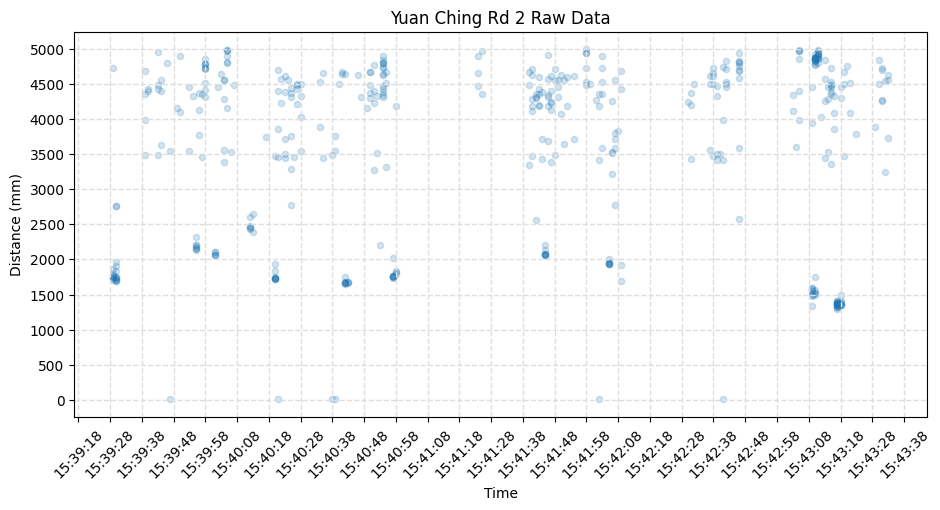

In [5]:
timings, distances, strengths = loader.filter_data_from_file(YUAN_CHING_RD_2, 5000)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 2 Raw Data", intervals=10, rotate_xticks=True)
plt.show()

After cleaning, the graph is left with a few very distinct clusters representing vehicle passes.

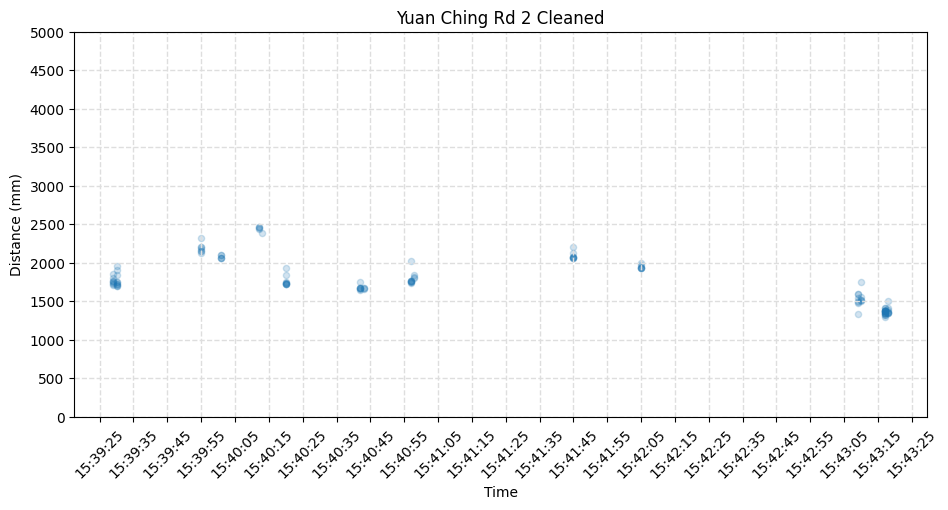

In [6]:
fig, axes = plt.subplots(figsize=(11, 5))
cleaned_distances = cleaner.clean_tof_data(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Yuan Ching Rd 2 Cleaned", intervals=10, rotate_xticks=True)
plt.show()

### Data Cross-Reference with Video Feed 2

- **General Observations**:
  - The cleaned data effectively pinpointed the clusters representing passing vehicles.
  - The first four clusters from 15:39:25 to 15:40:15 onwards were recorded before the video feed began.
  - The sensor missed a vehicle between 15:42:05 to 17:18:15. However, this missed vehicle might have been filtered out by the cleaning algorithm.
  - While the success rate of the sensor here was 1/7, with more vehicles it is likely to have a higher rate of success. Overall, I believe that the LIDAR sensor performs reliably in detecting vehicle-to-cyclist passing distances.

![LIDAR Yuan Ching Rd](../assets/annotated_graphs/LIDAR_yuan_ching_rd_2.png)

## On-Road Cycling Test

Finally, with the same setup, the bike was cycled along a 5km route alongside traffic in Singapore's Jurong West area. This experiment aims to demonstrate the effectiveness of the LIDAR-DepthAI setup in automatically collecting vehicle-to-cyclist passing distances.

### Jurong-West Ride Analysis

- **Setup and Initial Observations**:
  - The food delivery rider cycled a 5-6km loop on public roads exposed to traffic in the Jurong West area. At this time of day, traffic was light and not many vehicles overtook the cyclist in the same lane.
  - Compared to the stationary test, the number of spurious points produced over 3m have greatly increased. However, below 3m the clusters seem fairly isolated and reliable. Moreover, the data I'm concerned with falls below 2m. Hence, I should filter out points over 3m.
  - At a galnce it can also be seen that several clusters of data points fall below the 1.5m mark, suggesting that there were vehicles that overtook the cyclist too close even when traffic wasn't at its heaviest.
  - The large chunks of empty space indicate the areas where the AI camera did not detect any vehicles, thereby reducing the total noise.

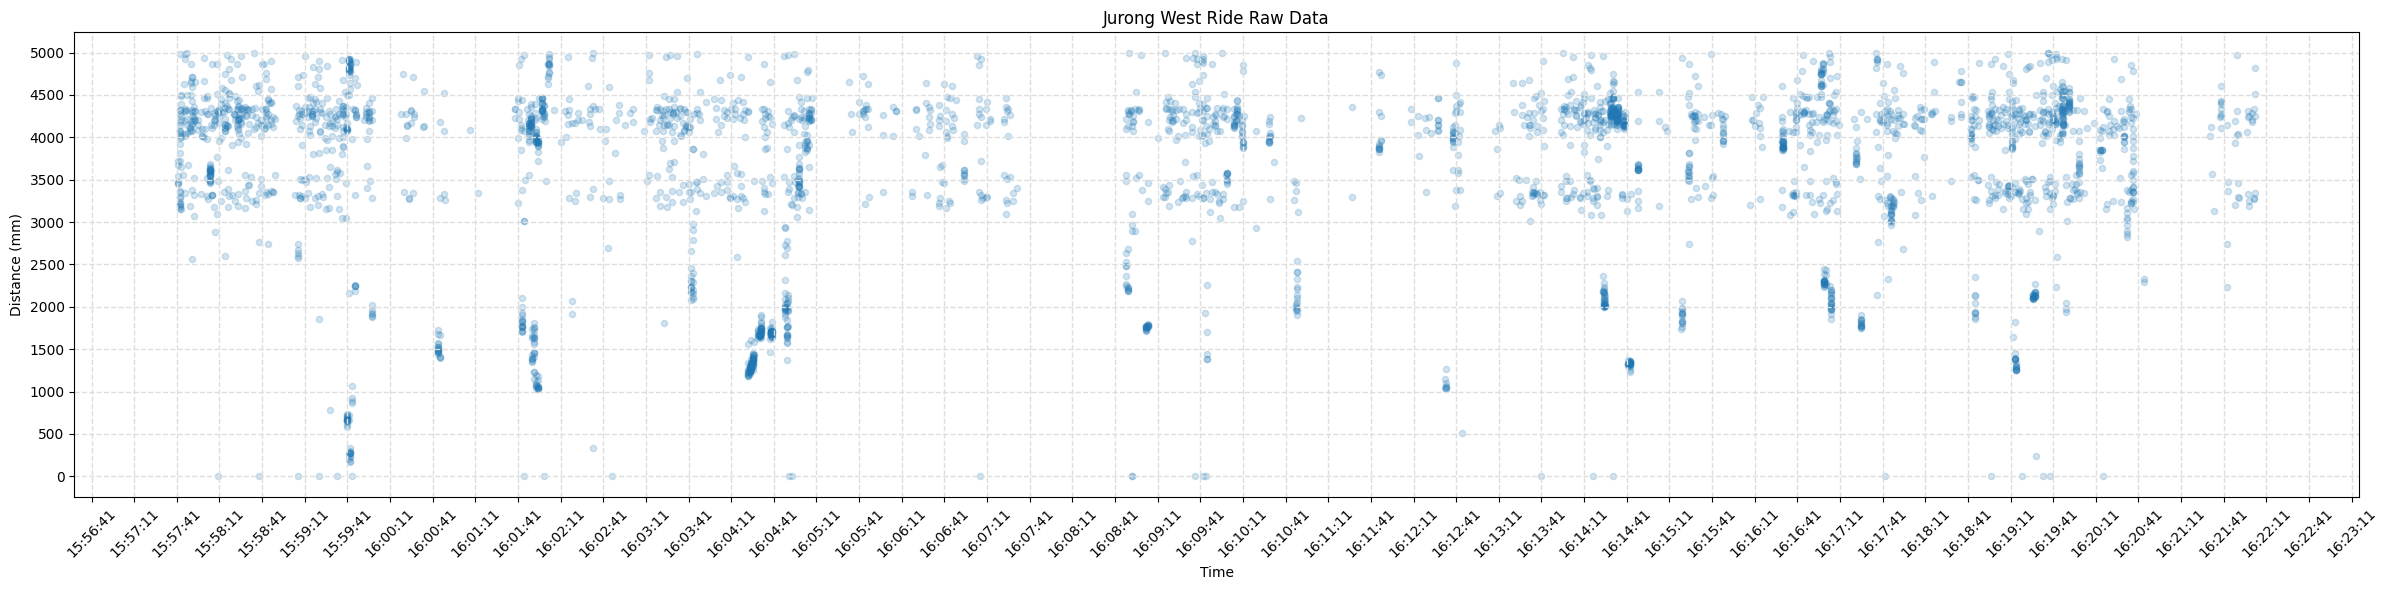

In [7]:
timings, distances, strengths = loader.filter_data_from_file(JURONG_WEST_RIDE, 5000)
cleaned_distances = cleaner.average_clusters(distances)

fig, axes = plt.subplots(figsize=(24, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Jurong West Ride Raw Data", 30, True)
plt.tight_layout()
plt.show()

- **Data Cleaning**:
  - First, I filtered out all points above 3m and below 0.5m.
  - Then, I applied the same cleaning algorithm as above.

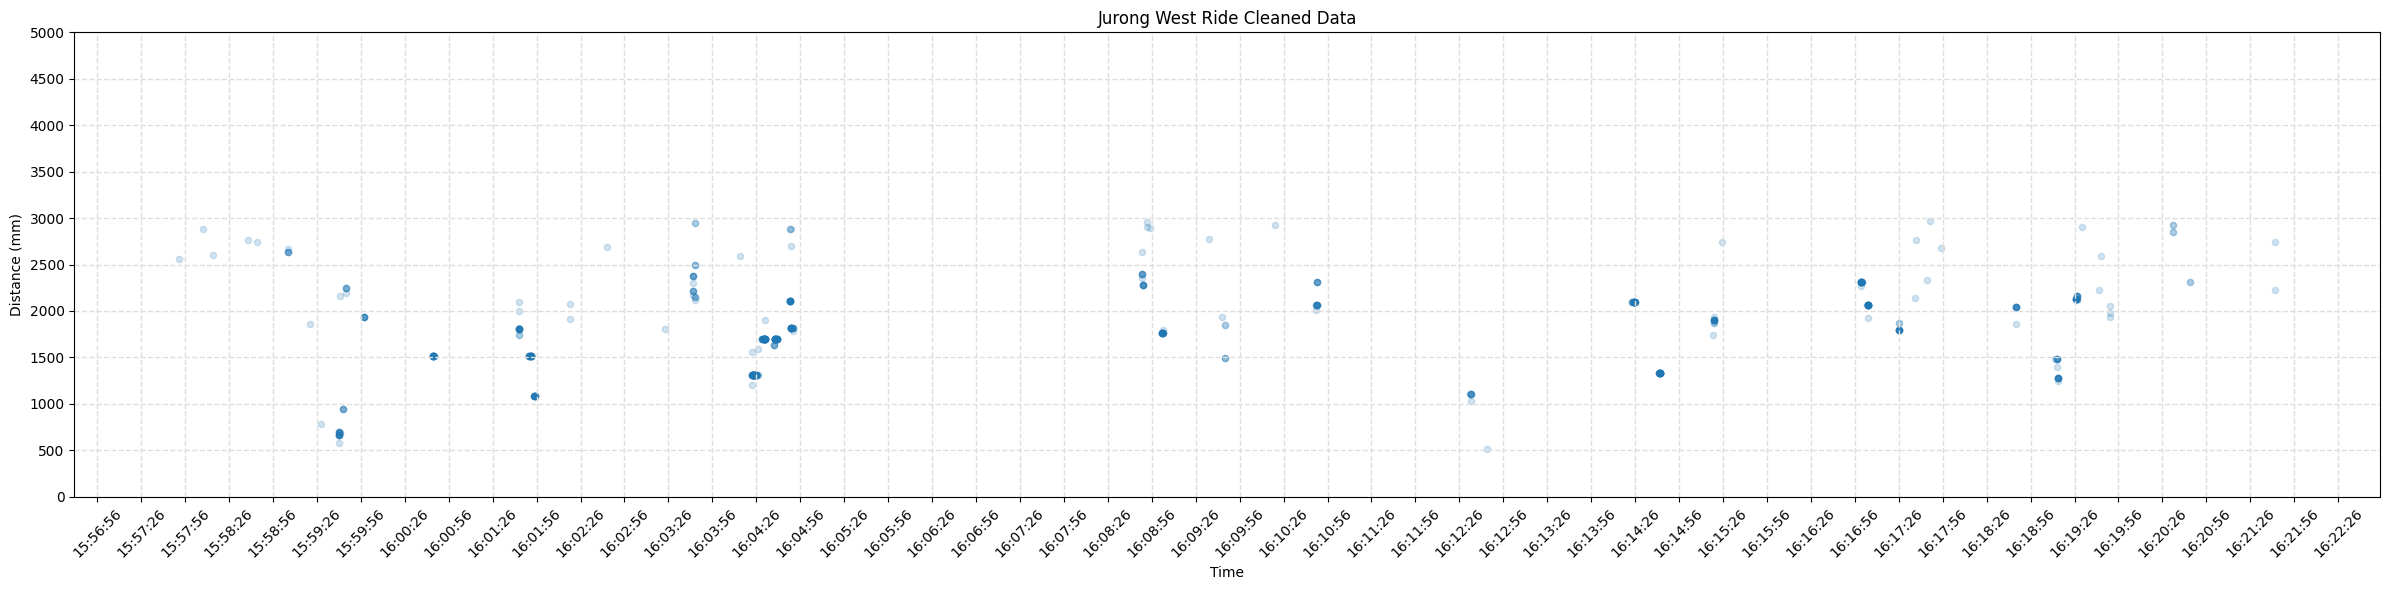

In [8]:
timings, distances, strengths = loader.filter_data_from_file(JURONG_WEST_RIDE, high=3000, low=500)
cleaned_distances = cleaner.average_clusters(distances)

fig, axes = plt.subplots(figsize=(24, 6))
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Jurong West Ride Cleaned Data", 30, True)
plt.tight_layout()
plt.show()

### Data Cross-Reference with Video Feed 3

- **Legend**:
  - Red Circles: Vehicles overtaking the cyclist.
  - Blue Circles: Stopped vehicles that the cyclist moves past.
- **Video-Assisted Analysis**:
  - Prior to the first red circle marked at 15:59:56, the displayed points are not accurate. This inaccuracy occurred when the bike exited a parking lot, causing the AI camera to register numerous points and prompting the sensor to measure distances to stationary objects.
  - On the whole, the sensor effectively identified overtaking vehicles without any misses. The only inconsistency arose from these inaccurate points. However, these points are distinguishable due to their lighter color, indicating they are not dominant clusters.
  - **Out of the 21 vehicles that overtook the cyclist within the same lane, 7 maintained a distance of 1.5m or less.**

![Jurong West Ride](../assets/annotated_graphs/LIDAR_jurong_west_ride.png)

## Automated Data Analysis

### Cluster Identification with DBSCAN

- **Objective**: To enhance efficiency in the data collection process, we aim to replace the time-consuming manual identification of clusters through cross-referencing with the Go Pro. Instead, an algorithmic approach that automatically recognizes clusters, representing vehicle passes, will be implemented.
- **DBSCAN**: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm which is good at filtering out noise/outlying data and it is robust in its ability to identify clusters without needing to specify the number of clusters beforehand.
- **Parameters**: `eps=0.02`, `min_samples=6`
  - **eps**: The epsilon parameter specifies the minimum distance between points for them to be considered in the same cluster.
  - **min_samples**: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
- **Results**:
  - **False Positives**: 3
  - **True Positives**: 23
  - **False Negatives**: 0
- **Limitations**: The potential of DBSCAN is shown in this example. However, the algorithm may not perform as well on other datasets. To find the optimal algorithm and hyper-parameters, a large amount of testing must be done. Nonetheless, the results here demonstrate the potential of automated cluster identification.

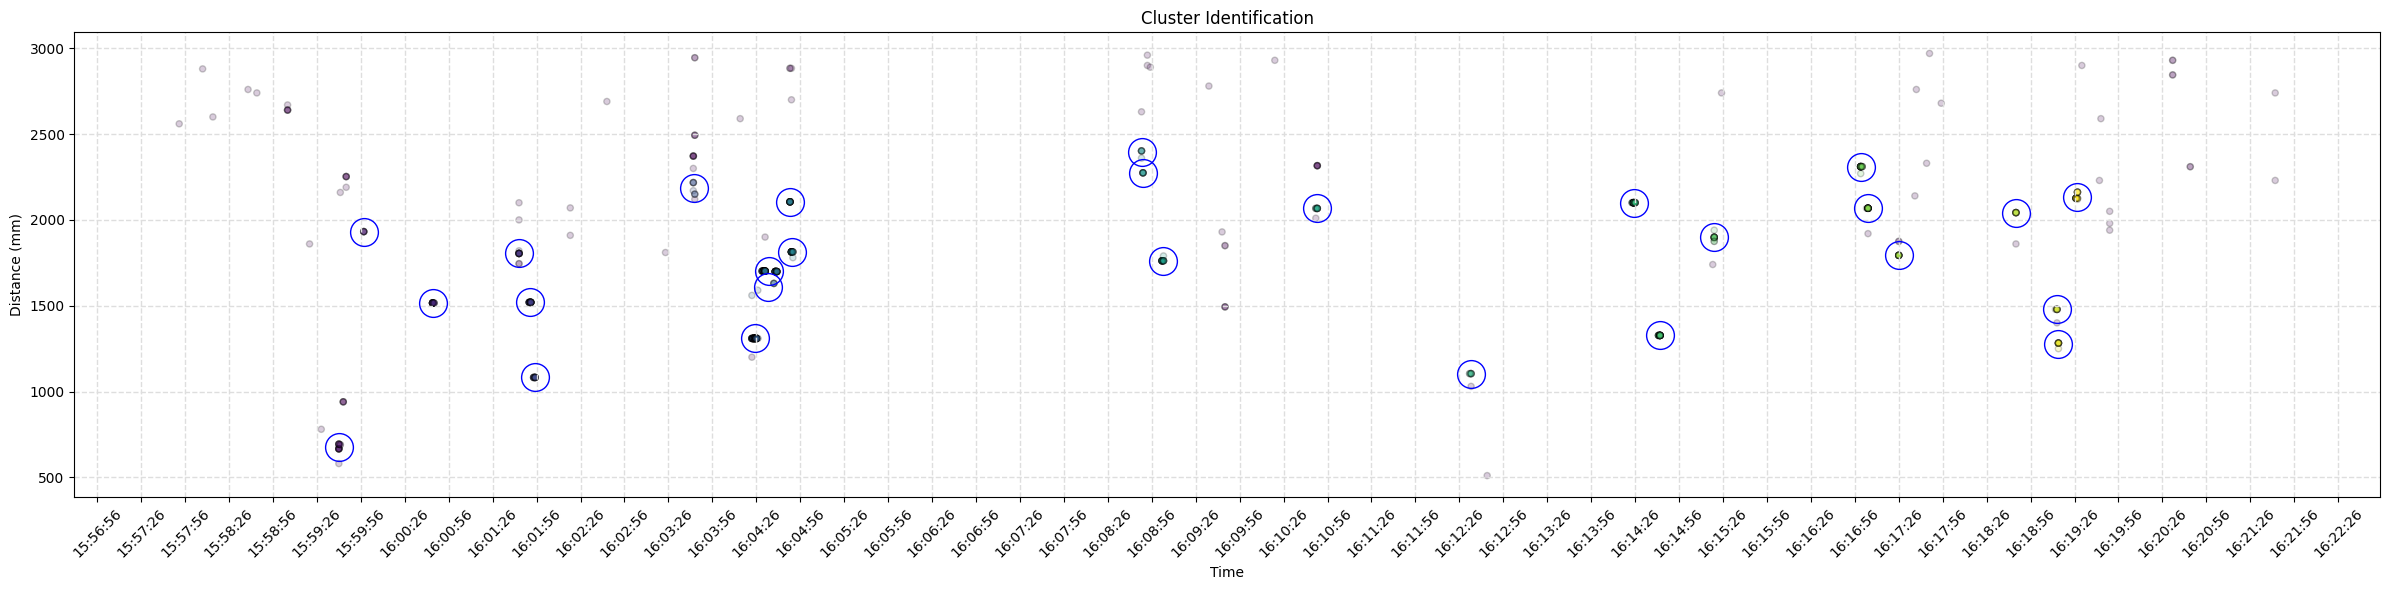

In [9]:
fig, ax = plt.subplots(figsize=(24, 6))
outdoor_graphs.scatter_clusters_with_dbscan(ax, timings, cleaned_distances, "Cluster Identification", 30, True)
plt.tight_layout()
plt.show()

### Identifying Close Passes with DBSCAN

- **Objective**: We can then define the average passing distance of vehicles as the average of the clusters identified by DBSCAN. In the graph below, each point represents the average distance of a vehicle pass. 
- **Cleaning**: We can filter out extreme data. It is improbable that vehicles would pass less than 1m so we can assume those clusters are spurious. Vehicle passes over 2m are likely not in the same lane so we can filter those out as well.
- **Data Visualization**: I highlighted the points from 1m to 1.5m, indicating that the points that fall in this range represent dangerous vehicle passes.

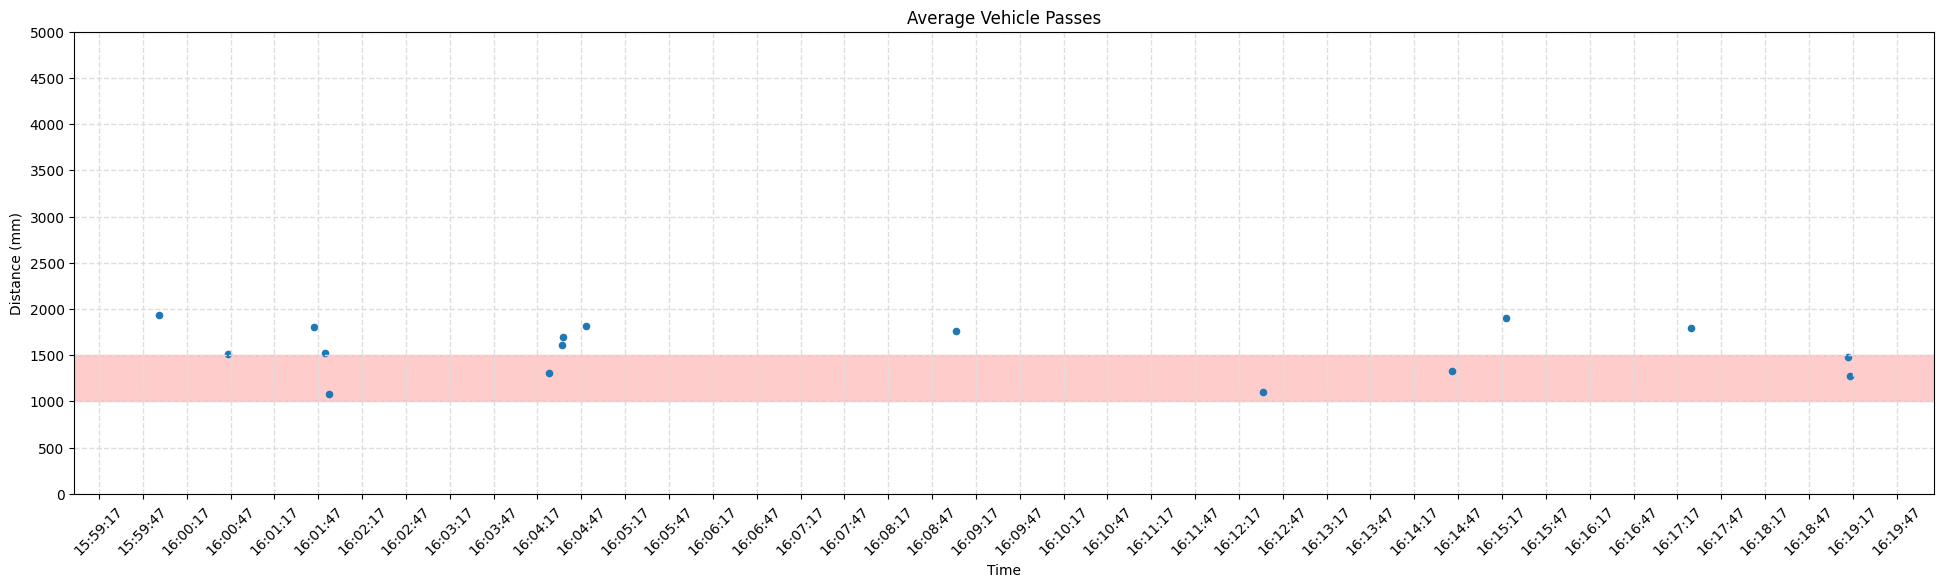

In [10]:
timestamps = processing.datetime_to_timestamps(timings)
clusters = analysis.find_clusters_DBSCAN(timestamps, cleaned_distances)
average_cluster_timings, average_cluster_distances = analysis.find_cluster_averages_DBSCAN(timings, cleaned_distances, clusters)

# Filter out all points below 1000.
average_cluster_timings, average_cluster_distances = zip(*sorted((t, d) for (t, d) in zip(average_cluster_timings, average_cluster_distances) if 1000 < d < 2000))

fig, ax = plt.subplots(figsize=(24, 6))
ax.axhspan(1000, 1500, alpha=0.2, color="r")
outdoor_graphs.scatter_time_vs_distance(ax, average_cluster_timings, average_cluster_distances, title="Average Vehicle Passes", rotate_xticks=True, alpha=1)
plt.show()

### Interactive Visualization

Below is an interactive visualization, allowing users to view overtaking vehicle images by clicking on data points. With DBSCAN, I no longer needed to manually associate each scatter point with its corresponding image. I simply used the points from the clusters identified in the above graph, and linked each point with its corresponding screenshot. From passing distances of 1m to 2m, DBSCAN is 100% accurate.

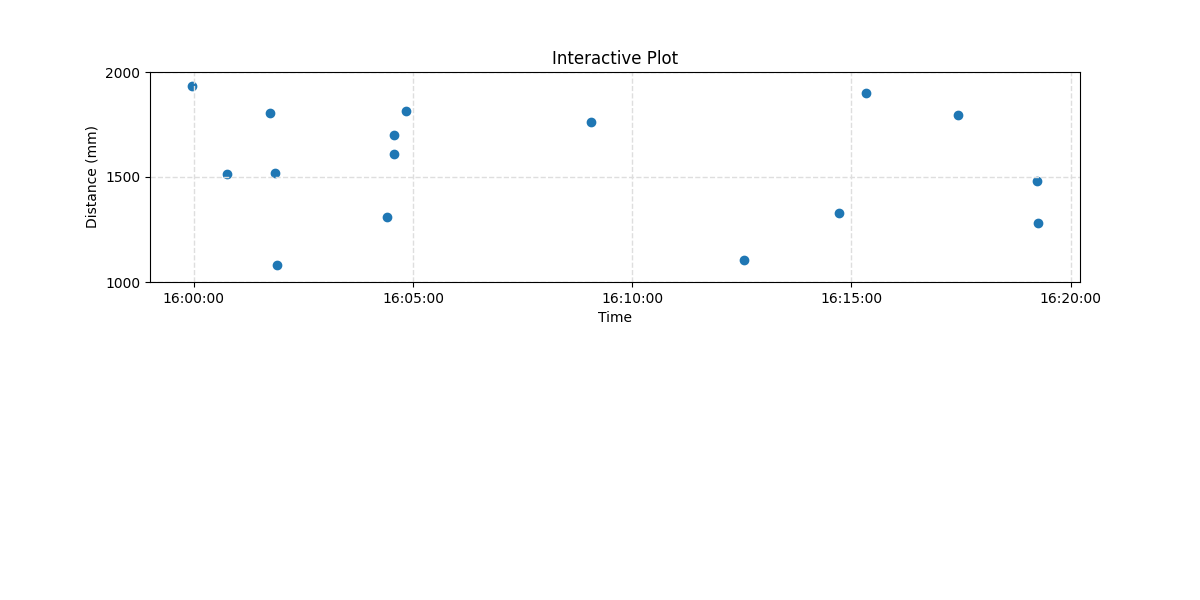

In [11]:
%matplotlib widget

images = sorted(list(pathlib.Path("../assets/screenshots/jurong_west_ride/").iterdir()), key=lambda x: int(x.name.split("-")[0]))

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
outdoor_graphs.interactive_scatter(fig, axes[0], axes[1], images, average_cluster_timings, average_cluster_distances, "Interactive Plot")
plt.show()

## Conclusion

The primary objective of the study was to evaluate the effectiveness of the Garmin's LIDAR Lite V4 in detecting and gauging distances of vehicles in genuine outdoor settings.

1. **Stationary Tests**:
   - In the initial test with the sensor on a stationary bike, the sensor demonstrated the capability to reliably detect passing vehicles, although there were spurious data
   points, especially above 3.5 meters.
   - A cleaning algorithm was effective in removing these spurious points and retaining the significant clusters representing passing vehicles.
   - The integration of the DepthAI's AI camera with the LIDAR improved the data quality by autonomously verifying a vehicle's proximity to the bike. This setup yielded cleaner data with fewer spurious points.
2. **Dynamic Test**:
   - For the on-road cycling test, where the bike was in motion, the LIDAR-DepthAI setup automatically collected vehicle-to-cyclist passing distances.
   - Even though there were more spurious points produced over 3 meters, data clusters below 3 meters appeared reliable. Significantly, several data points were below the 1.5 meters mark, indicating potentially risky overtakes by vehicles.
3. **Automated Data Analysis**:
   - DBSCAN was introduced as a tool for automated cluster identification, offering a promising potential to replace manual identification. For the dataset tested, it yielded a high true positive rate, although there were some false positives.
   - DBSCAN's performance emphasized the ability to automate the data collection process, increasing efficiency.
   - A specific application of DBSCAN was also highlighted in identifying close vehicle passes. The algorithm could pinpoint "dangerous" overtakes, with distances between 1m to 1.5m.

In summary, the Garmin's LIDAR Lite V4, especially when paired with DepthAI's AI camera, demonstrated reliable performance in an outdoor setting for the detection and measurement of passing vehicle distances. The study also showed the potential of automating the data collection and analysis process through the use of clustering algorithms like DBSCAN. However, it's essential to consider the limitations highlighted, such as potential false positives and the need for extensive testing across various datasets to ascertain the universal reliability of the methods used.